In [1]:
import pandas  as pd
import os
import numpy as np
%matplotlib inline

In [2]:
inVcfDir='/data/cellardata/users/btsui/dbsnp/Homo_sapiens/All_20170710.f1_byte2_not_00.vcf.gz' 
vcfDf=pd.read_csv(inVcfDir,sep='\t',header=None)
vcfDf.columns=['Chr','Pos','RsId','RefBase','AltBase','','','Annot']
vcfDf['Chr']=vcfDf['Chr'].astype(str)


/cellar/users/btsui/anaconda3/lib/python3.6/site-packages/IPython/core/interactiveshell.py:2785: DtypeWarning: Columns (0) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


In [3]:
vcfDf.drop_duplicates(['Chr','Pos']).shape

(387950, 8)

In [4]:
#'\w{22}'

In [5]:
vcfDf['VP_Int']=vcfDf['Annot'].str.extract('VP=(0x\w+)',expand=False).apply(lambda Str:int(Str,16))

In [6]:
#from right to left
nth_bit=6
vcfDf['somatic']=(vcfDf['VP_Int']%(2**(nth_bit-1))).astype(bool).values

In [7]:
vcfDf['specificSNP']=vcfDf['AltBase'].str.contains('^[ACGT]$')

In [8]:
somaticI=vcfDf[vcfDf['somatic']&vcfDf['specificSNP']].set_index(['Chr','Pos','AltBase']).index

In [9]:
germline_I=vcfDf[(~vcfDf['somatic'])&vcfDf['specificSNP']].set_index(['Chr','Pos','AltBase']).index

In [10]:
#somatic_I=vcfDf.set_index('AltBase')

In [11]:
myG=['Run_db','Run_digits',u'Chr', u'Pos',u'base']
vcfDf.head()

Chr     Pos        RsId RefBase AltBase        \
0   1   14727   rs1045587       G       A  .  .   
1   1  630825   rs9783068       T       C  .  .   
2   1  630833   rs9701099       C       T  .  .   
3   1  817186   rs3094315       G       A  .  .   
4   1  833068  rs12562034       G       A  .  .   

                                               Annot  \
0  RS=1045587;RSPOS=14727;RV;dbSNPBuildID=117;SSR...   
1  RS=9783068;RSPOS=630825;dbSNPBuildID=119;SSR=1...   
2  RS=9701099;RSPOS=630833;dbSNPBuildID=119;SSR=1...   
3  RS=3094315;RSPOS=817186;RV;dbSNPBuildID=103;SS...   
4  RS=12562034;RSPOS=833068;dbSNPBuildID=120;SSR=...   

                         VP_Int  somatic  specificSNP  
0  1547614017554423799187767552    False         True  
1  1547613980660935651768664384    False         True  
2  1547613980660935651768664384    False         True  
3  1548822906480573393185800449     True         True  
4  1548823017161040034332147968    False         True

In [12]:
refI=vcfDf.set_index(['Chr','Pos','RefBase']).index

In [13]:
tmp_dir='/nrnb/users/btsui/Data/all_seq/tmp/'

In [14]:
inFnameS=pd.Series(os.listdir(tmp_dir)).sample(n=30)

In [15]:
#!mkdir /tmp/btsui/jupyter/

In [16]:
varToPlot='pass rd'

In [51]:
myG=['ref base','Run_db','Run_digits']


In [117]:
#inFname=inFnameS.iloc[1]
#tmpDf=pd.read_pickle(tmp_dir+inFname)
#tmpDf

In [119]:
#inFname=inFnameS.iloc[1]
def inF(inFname):
    try:
        tmpDf=pd.read_pickle(tmp_dir+inFname)
    except:
        print ('failed:',inFname)
        return None
    tmpDf2=tmpDf[tmpDf['AverageBaseQuality']>=30].reset_index().drop_duplicates()
    myI=tmpDf2.set_index(['Chr','Pos','base']).index
    
    m_inRef=myI.isin(refI)
    m_somatic=myI.isin(somaticI)
    m_germline=myI.isin(germline_I)
    tmpDf2.loc[m_inRef,'ref base']='Reference alleles'
    tmpDf2.loc[m_somatic,'ref base']='Known somatic \nmutations'
    tmpDf2.loc[m_germline,'ref base']='Known germline \nmutations'
    
    tmpDf2['ref base'].fillna('Known germline \nmutations',inplace=True)

    tmpDf2['pass rd']=tmpDf2['ReadDepth']>=2
    #myG=['ref base','base','Run_db','Run_digits']
    
    tmpS=tmpDf2.groupby(myG)[varToPlot].sum()
    tmpS.to_pickle('/tmp/btsui/jupyter/'+inFname)
    return tmpS


In [120]:


from multiprocessing import Pool

In [121]:
from tqdm import tqdm
import matplotlib.pyplot as plt
import seaborn as sns

In [122]:
#tmpSL=list(tqdm(map(inF,inFnameS.values),
#                   total=len(inFnameS)))

In [123]:
#take one hour and twenty mins
#ls_out.txt: screwed up the process
with Pool(48) as p:
    tmpSL=list(tqdm(p.imap(inF,inFnameS.values),total=len(inFnameS)))#,
                   #total=len(inFnameS))

100%|██████████| 30/30 [00:44<00:00,  1.49s/it]


In [124]:
#tmpSL[0]

In [125]:
#len(tmpSL)

In [126]:
mergeS_raw=pd.concat(tmpSL,axis=0)#.groupby(myG).sum()

In [128]:
import matplotlib.pyplot as plt
import matplotlib 

In [129]:
from scipy import stats

In [138]:
mergeS_raw

ref base                    Run_db  Run_digits
Known germline \nmutations  ERR     239961           371.0
                                    241131          1084.0
                                    243497           370.0
                                    245894           989.0
                                    1491058           27.0
                                    1492457           15.0
                                    1564065           14.0
                                    1570499           12.0
                            SRR     32267           7362.0
                                    42258            208.0
                                    66791          18070.0
                                    71133          24472.0
                                    227398            26.0
                                    351624           423.0
                                    443595          1716.0
                                    568343          4462.0
         

In [137]:
(mergeS_raw[mergeS_raw.index.get_level_values('ref base')!='Reference alleles'])#.median()

ref base                    Run_db  Run_digits
Known germline \nmutations  ERR     239961          371.0
                                    241131         1084.0
                                    243497          370.0
                                    245894          989.0
                                    1491058          27.0
                                    1492457          15.0
                                    1564065          14.0
                                    1570499          12.0
                            SRR     32267          7362.0
                                    42258           208.0
                                    66791         18070.0
                                    71133         24472.0
                                    227398           26.0
                                    351624          423.0
                                    443595         1716.0
                                    568343         4462.0
                         

In [131]:
stats.ttest_ind(np.log2(mergeS_raw['Known germline \nmutations']+1),np.log2(mergeS_raw[mergeS_raw.index.get_level_values('ref base')!='Reference alleles']+1))

Ttest_indResult(statistic=18.572893988239873, pvalue=1.4421949945566788e-75)

In [132]:
mergeS_raw.groupby('ref base').median()

ref base
Known germline \nmutations     3068.0
Known somatic \nmutations       337.0
Reference alleles             19930.0
Name: pass rd, dtype: float64

Text(0.5,0,'')

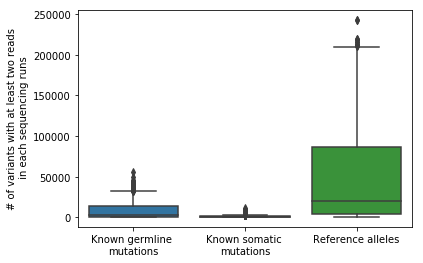

In [139]:
ax=sns.boxplot(data=mergeS_raw.reset_index(),x='ref base',y='pass rd')
ax.set_ylabel('# of variants with at least two reads\n in each sequencing runs')
ax.set_xlabel('')
#ax.set_yscale('log')
#ax.get_yaxis().set_major_formatter(
#    matplotlib.ticker.FuncFormatter(lambda x, p: format(int(x), ',')))


In [84]:
(mergeS_raw>2000).groupby('ref base').mean()

ref base
Known germline \nmutations    0.587196
Known somatic \nmutations     0.133583
Reference alleles             0.846616
Name: pass rd, dtype: float64

In [75]:
mergeS_raw.groupby('ref base').median()

ref base
Known germline \nmutations     3608.0
Known somatic \nmutations       384.5
Reference alleles             23044.0
Name: pass rd, dtype: float64

In [76]:
#mergeS_raw[~(mergeS_raw.index.get_level_values('ref base')=='Reference alleles')]

In [66]:
minorAllelS=mergeS_raw[~(mergeS_raw.index.get_level_values('ref base')!='Reference alleles')]

In [69]:
#minorAllelS

In [73]:
(minorAllelS>1000).median()

1.0

In [61]:
mergeS_raw.median()

2471.5

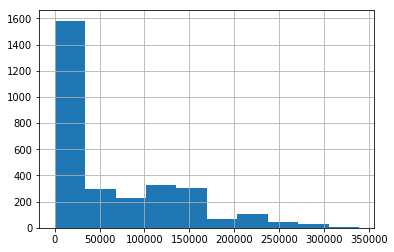

In [35]:
mergeS_raw.hist()

In [26]:
mergeS_raw=mergeS_raw.groupby(myG).sum()

In [27]:
mergedS=np.log10(mergeS_raw+1)

In [32]:
mergedS.head()

Run_db  Run_digits
DRR     61036         5.055466
ERR     6319          3.775028
        6338          4.457019
        6358          3.744762
        6376          4.650094
        6422          4.491320
        15993         4.365113
        16147         4.581540
        16149         4.993908
        16177         4.762829
        16213         5.020034
        16217         4.541205
        16251         5.168886
        16257         4.703996
        16267         5.075006
        16307         4.379541
        18464         5.090322
        19901         4.592177
        22333         4.751164
        22355         4.689309
        22379         4.396356
        22444         4.426853
        22449         5.281465
        31876         5.367432
        31879         5.362268
        31920         5.475671
        31984         5.407880
        32040         5.262268
        42505         5.497302
        42532         5.491119
                        ...   
SRR     6040477     

In [29]:
#%matplotlib inline
plt.rcParams['pdf.fonttype'] = 42


In [30]:
mergeS_raw.groupby('ref base').median()

KeyError: 'ref base'

ValueError: Could not interpret input 'ref base'

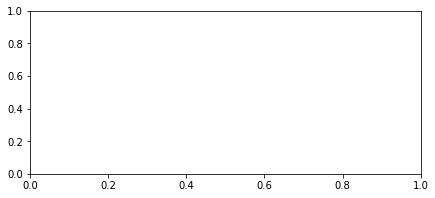

In [31]:
fig,ax=plt.subplots(figsize=(7,3))
xorder=['Reference alleles','Known germline \nmutations','Known somatic \nmutations']
ax=sns.boxplot(data=mergedS.reset_index(),
               x='ref base',y=varToPlot,ax=ax,order=xorder)
#    tmpDf2.loc[m_inRef,'ref base']='Reference alleles'
#    tmpDf2.loc[m_somatic,'ref base']='Known somatic \nmutations'
#    tmpDf2.loc[m_germline,'ref base']='Known germline \nmutations'
#ax.set_xticks()
#at least 2 reads
#each dot is a variant
#ax.set_yscale('log')
#ax.set_ylim([0,10**6])
#ax.ticklabel_format(axis='y',style='sci',scilimits=(1,4))

ax.set_ylabel(' # of sequencing runs with variant detected\n (log10 scale)' )
#ax.set_xlabel()
ax.set_xlabel('')
fig.savefig('./Figures/variant_suppport_for_each_sequencing_run.pdf')
fig.savefig('./Figures/variant_suppport_for_each_sequencing_run.png',dpi=300)

In [66]:
!echo $PWD/./Figures/variant_suppport_for_each_sequencing_run.pdf

/cellar/users/btsui/Project/METAMAP/notebook/RapMapTest/Analysis/./Figures/variant_suppport_for_each_sequencing_run.pdf


In [258]:
#ax=mergedS[False].hist()

In [60]:
### make sure the data read in will have all the results
inFname=inFnameS.iloc[1]

tmpDf=pd.read_pickle(tmp_dir+inFname)

tmpDf2=tmpDf.reset_index().drop_duplicates()



#tmpDf2.head().dtypes

myI=tmpDf2.set_index(['Chr','Pos','base']).index

m_inRef=myI.isin(refI)

tmpDf2.loc[m_inRef,'ref base']=True

tmpDf2['ref base'].fillna(False,inplace=True)

tmpDf2['pass rd']=tmpDf2['ReadDepth']>=2

tmpS=tmpDf2.groupby(['ref base','base','Run_db','Run_digits'])['pass rd'].sum()

In [1]:
#tmpS

In [161]:
import matplotlib.pyplot as plt

/cellar/users/btsui/anaconda3/lib/python3.6/site-packages/matplotlib/axes/_axes.py:6462: UserWarning: The 'normed' kwarg is deprecated, and has been replaced by the 'density' kwarg.
  warnings.warn("The 'normed' kwarg is deprecated, and has been "


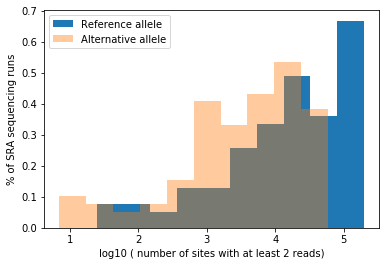

In [165]:
fig,ax=plt.subplots()
g=tmpDf2[tmpDf2['ref base']].groupby(['base','Run_db','Run_digits'])['pass rd']
countS1=np.log10(g.sum())
countS1.hist(normed=True,ax=ax,label='Reference allele')

g=tmpDf2[~tmpDf2['ref base']].groupby(['Run_db','Run_digits'])['pass rd']
countS2=np.log10(g.sum())
countS2.hist(normed=True,ax=ax,alpha=0.4,label='Alternative allele')
#'log10 ( number of sites with at least 2 reads)' , '% of SRA sequencing runs'
ax.set_ylabel('% of SRA sequencing runs')
ax.legend()
ax.set_xlabel('log10 ( number of sites with at least 2 reads)')
ax.grid(False)

In [163]:
from scipy import stats

In [ ]:
stats.wilcoxon(countS1,countS2)

In [ ]:
type(myI),

In [42]:
m_inRef.mean()

0.7398492072866819

In [ ]:
tmpDf=pd.read_pickle(tmp_dir+inFnameS.iloc[0])

In [150]:
tmpDf

features                            ReadDepth  AverageBaseQuality
Run_db Run_digits Chr Pos     base                               
ERR    18506      1   14727   A             2                  15
                              G             2                  27
                      630825  G             2                  13
                              T           165                  33
                      630833  C           180                  33
                              G             1                   7
                      842133  A             1                   7
                              G             1                  33
                      843942  A             2                  31
                      850609  C             2                  33
                      970788  G             1                  38
                      1014143 C             3                  30
                      1014228 G             2                  22
                      1014316 C             1                  28
                      1014359 G             2                  38
                      1022188 A             1                  33
                      1022225 G             1                  18
                      1022260 C             1                  22
                      1041582 G             1                  10
                      1041583 A             1                   6
                      1043476 G             1                  30
                      1044134 G             1                  11
                      1044176 G             1                  29
                      1044455 G             1                  35
                      1045172 G             1                  12
                      1045177 G             1                   6
                      1045393 C             1                  14
                      1045707 G             1                  28
                      1045751 A             1                  36
                      1045785 G             1                  39
...                                       ...                 ...
SRR    5981338    MT  15784   T          3786                  37
                      15812   A             4                  16
                              C             1                   2
                              G          3138                  37
                              T             1                   2
                      15833   A             2                   5
                              C          2133                  37
                      15848   A          1446                  37
                              G             1                   7
                              T             3                  28
                      15884   G           236                  34
                      15890   A            93                  34
                              C             8                  37
                      15923   A             1                  36
                      15927   G             1                  36
                      15928   G             1                  37
                      15932   T             1                  37
                      15943   T             3                  39
                      15950   G             3                  40
                              T             1                  34
                      15965   A             6                  39
                      15967   G             6                  39
                      15990   C            31                  36
                      16188   A             1                   2
                              C           194                  26
                      16278   C           280                  37
                      16390   C             1                   2
                              G         